In [ ]:
# === colab configuration ===

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.cloud.Deeplabv3 import deeplabv3
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
from models import config
from slurm_scripts import slurm_config

In [3]:
# defining transforms
image_transform = T.Compose([T.Resize(slurm_config.GLOBAL_INPUT_SIZE_TRAINING_DEMO), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize(slurm_config.GLOBAL_INPUT_SIZE_TRAINING_DEMO)])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
_, X_test, _, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
test_dataset = dataset.CcncsaDataset(X_test, Y_test, image_transform, target_transform)

# loading model
model_name = 'deeplabv3_ccncsa_demo'
model = deeplabv3.deeplabv3_resnet50(num_classes=n_classes)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(weights_path_drive + model_name + '.pth'))

# testing model on test dataset
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_score_fn = metrics.batch_IoU
class_weights = torch.tensor(config.CLASS_WEIGHTS, device=device)
batch_IoU = training_and_testing.test_model(device, model, test_dataset, batch_size, test_score_fn)

# printing test report
training_and_testing.print_IoU_report(batch_IoU, class_weights)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Device: cuda.

Inference completed in around 89 seconds.
batch_IoU_background: 0.9608992338180542
batch_IoU_lips: 0.5796565413475037
batch_IoU_eyes: 0.48280903697013855
batch_IoU_nose: 0.7678164839744568
batch_IoU_skin: 0.8773354291915894
batch_IoU_hair: 0.8262379169464111
batch_IoU_eyebrows: 0.4571354389190674
batch_IoU_ears: 0.7346693277359009
batch_IoU_teeth: 0.7045495510101318
batch_IoU_beard: 0.8843770623207092
batch_IoU_sunglasses: 0.9254170060157776
batch_mIoU=0.7455366253852844
batch_weighted_mIoU=0.728227436542511


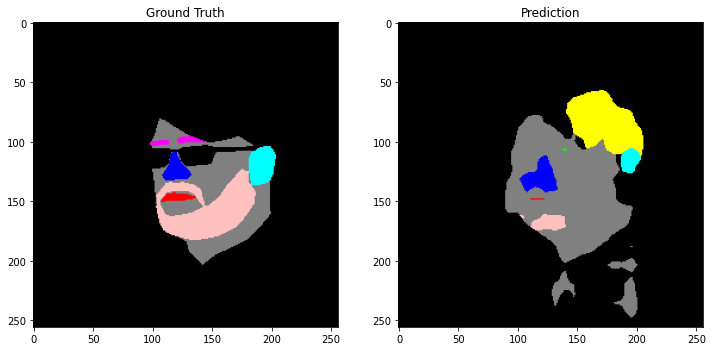

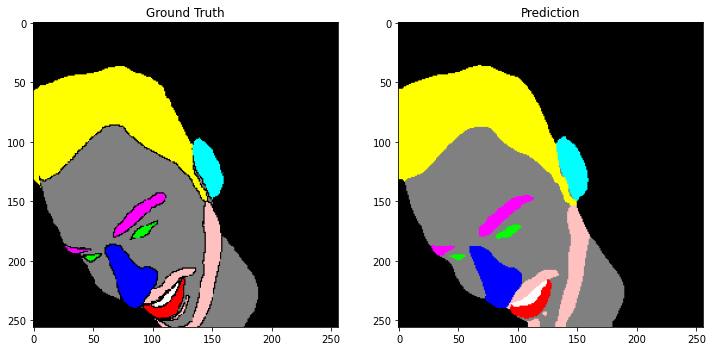

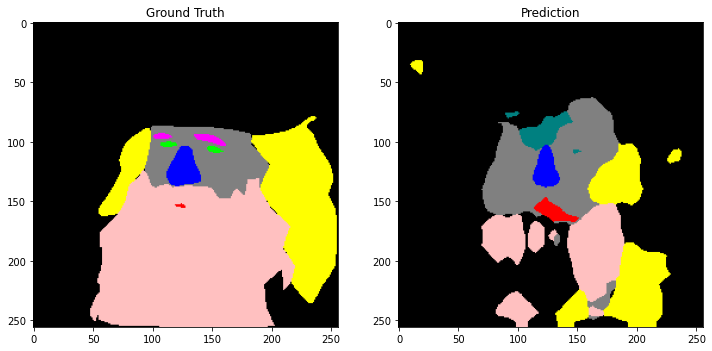

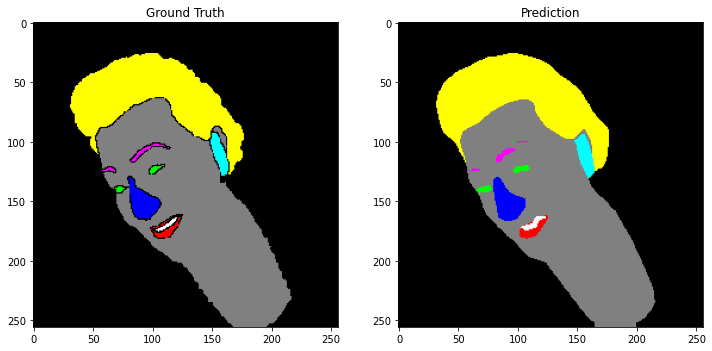

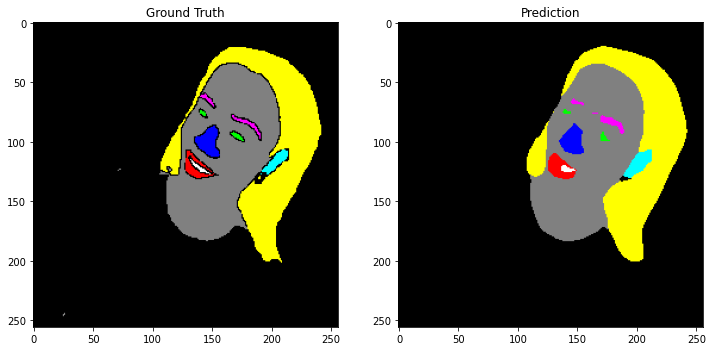

In [4]:
# plotting some examples from test dataset
utils.plot_random_examples(device, model, test_dataset, n_examples=5)